In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style="whitegrid")

!apt-get update
!apt-get install -y cmake g++ build-essential git

!rm -rf /content/dismecpp

# 1. Clone DiSMEC++ with all submodules
!git clone --recursive https://github.com/xmc-aalto/dismecpp.git /content/dismecpp

# 2. Fix pybind11 to compatible version
%cd /content/dismecpp/deps/pybind11
!git checkout v2.11.1

# 3. Create build directory and compile
%cd /content/dismecpp
!mkdir -p build
%cd build
!cmake .. && make -j4

# 4. Verify that the 'train' binary exists
!ls -l ./bin/train


Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,851 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [4,976 kB]
Get:13 https://r2u.stat.illinois.edu

In [ ]:
import os
os.getcwd()

In [ ]:
!ls /content/dismecpp/src

app.cpp		config.h  matrix_types.h  predict.cpp  solver	 train.cpp
app.h		data	  model		  prediction   stats	 training
cascade.cpp	fwd.h	  objective	  pybind.cpp   test.cpp  utils
CMakeLists.txt	io	  parallel	  python       tools


In [ ]:
# ! /dismecpp/src/train train_eurlex.txt eurlex.model \
#   --augment-for-bias \
#   --normalize-instances \
#   --save-sparse-txt \
#   --weight-culling=0.01

In [ ]:
# /content/dismecpp/src/train.cpp

In [ ]:
!/content/dismecpp/build/bin/train  /content/train_eurlex.txt eurlex.model --augment-for-bias --normalize-instances --save-sparse-txt --weight-culling=0.01

[2025-07-10 08:36:22.432] [info] Loading training data from file '/content/eurlex_train.txt'
[2025-07-10 08:36:22.432] [info] Loading dataset '/content/eurlex_train.txt' with 15539 examples, 5000 features and 3993 labels.
[2025-07-10 08:36:23.118] [info] Finished loading dataset '/content/eurlex_train.txt' in 0.686s.
[2025-07-10 08:36:23.118] [info] Normalizing instances.
[2025-07-10 08:36:23.124] [info] Appending bias features with value 1
[2025-07-10 08:36:23.167] [info] Processed feature matrix has 15539 rows and 5001 columns. Contains 3700312 non-zeros (4.76 %)
[2025-07-10 08:36:23.167] [info] handled preprocessing in 0 seconds
[2025-07-10 08:36:23.167] [info] Start training
[2025-07-10 08:36:23.167] [info] Starting batch 0 - 3993
[2025-07-10 08:36:23.341] [info] Thread 1 finished minimization for label     0 in   11 iterations (155ms) with loss 1.55e+04 ->   5.06 and gradient 3.17e+04 -> 0.0467.
[2025-07-10 08:36:23.371] [info] Thread 0 finished minimization for label     1 in    

In [ ]:
!/content/dismecpp/build/bin/predict /content/test_eurlex.txt eurlex.model eurlex_pred.txt --augment-for-bias --normalize-instances --topk=5

data-file: File does not exist: /content/test_eurlex.txt
Run with --help for more information.


In [ ]:
def parse_true_labels(file_path):
    labels = []
    with open(file_path) as f:
        for line in f:
            line = line.strip()
            if not line or ':' in line.split()[0]:  # ignore header or malformed lines
                continue
            label_str = line.split()[0]  # '3,4,52,...'
            try:
                label_ids = list(map(int, label_str.split(",")))
                labels.append(label_ids)
            except ValueError:
                print(f"Skipping malformed line: {line}")
    return labels

def parse_predicted_scores(file_path):
    scores = []
    with open(file_path) as f:
        for line in f:
            line = line.strip()
            if not line or ':' not in line:
                continue
            parts = line.strip().split()
            score_dict = {}
            for item in parts[1:]:  # skip label field
                if ':' in item:
                    idx, val = item.split(":")
                    score_dict[int(idx)] = float(val)
            scores.append(score_dict)
    return scores


In [ ]:
def get_top_k_predictions(score_dicts, k):
    return [sorted(scores.items(), key=lambda x: -x[1])[:k] for scores in score_dicts]

def precision_at_k(y_true, y_pred, k):
    precisions = []
    for true_labels, pred in zip(y_true, y_pred):
        pred_labels = [label for label, _ in pred[:k]]
        tp = len(set(true_labels) & set(pred_labels))
        precisions.append(tp / k)
    return sum(precisions) / len(precisions)

def ndcg_at_k(y_true, y_pred, k):
    import math
    def dcg(rel):
        return sum((2**r - 1) / math.log2(i + 2) for i, r in enumerate(rel))

    def idcg(rel):
        return dcg(sorted(rel, reverse=True))

    ndcg_scores = []
    for true, pred in zip(y_true, y_pred):
        pred_labels = [label for label, _ in pred[:k]]
        rel = [1 if label in true else 0 for label in pred_labels]
        if sum(rel) == 0:
            ndcg_scores.append(0.0)
        else:
            ndcg_scores.append(dcg(rel) / idcg(rel))
    return sum(ndcg_scores) / len(ndcg_scores)


In [ ]:
def evaluate_all(true_file, pred_file, k_list):
    y_true = parse_true_labels(true_file)
    y_scores = parse_predicted_scores(pred_file)

    results = {}
    for k in k_list:
        top_k_preds = get_top_k_predictions(y_scores, k)
        results[f"Precision@{k}"] = precision_at_k(y_true, top_k_preds, k)
        results[f"nDCG@{k}"] = ndcg_at_k(y_true, top_k_preds, k)

    return results


In [ ]:
true_file = "/content/test_eurlex.txt"
pred_file = "/content/dismecpp/build/eurlex_pred.txt"

k_list = [1, 3, 5]
results = evaluate_all(true_file, pred_file, k_list)

import json
print(json.dumps(results, indent=4))

In [ ]:
# !git clone https://github.com/kunaldahiya/pyxclib.git
# %cd pyxclib
# !python3 setup.py install --user

In [ ]:
# from xclib.data import data_utils

# # Read file with features and labels (old format from XMLRepo)
# features, tabels, num_samples, num_features, num_labels = data_utils.read_data('train.txt')

# # Read sparse file (see docstring for more)
# # header can be set to false (if required)
# labels = data_utils.read_sparse_file('trn_X_Xf.txt', header=True)

# # Write sparse file (with header)
# data_utils.write_sparse_file(labels, "labels.txt")

In [ ]:
# from xclib.data import data_utils
# import xclib.evaluation.xc_metrics as xc_metrics

# # Read ground truth and predictions
# true_labels = data_utils.read_sparse_file('tst_X_Y.txt')
# predicted_labels = data_utils.read_sparse_file('parabel_predictions.txt')

# # evaluate (See examples/evaluate.py for more details)
# acc = xc_metrics.Metrics(true_labels=true_labels)
# args = acc.eval(predicted_labels, 5)
# print(xc_metrics.format(*args))

/tmp/ipython-input-3-2882928411.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_melted, x='Dataset', y='Score', hue='Method', palette='muted', ci=None)


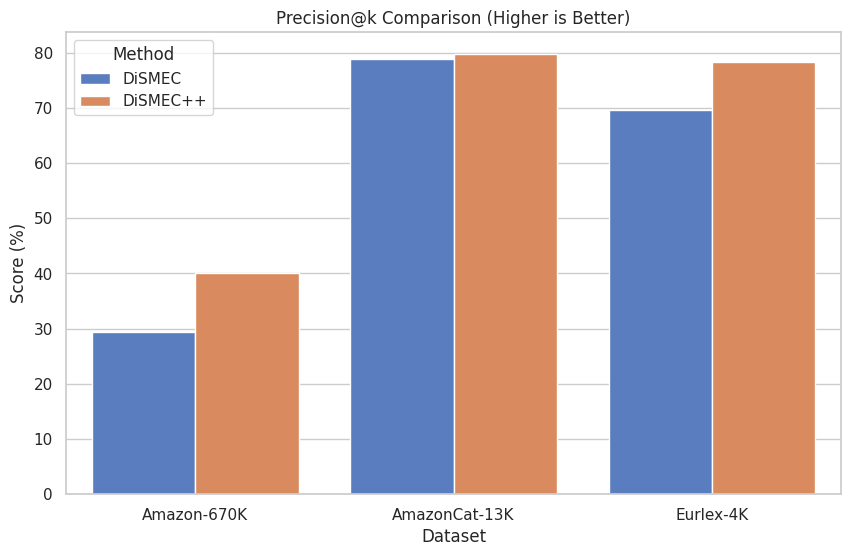

In [3]:
data = {
    'Dataset': ['Amazon-670K', 'AmazonCat-13K', 'Eurlex-4K'] * 2,
    'Method': ['DiSMEC'] * 3 + ['DiSMEC++'] * 3,
    'P@1': [37.02, 93.4, 82.4, 45.7, 94.9, 89.4],
    'P@3': [29.03, 79.1, 68.5, 36.7, 82.14, 78.5],
    'P@5': [22.15, 64.1, 57.7, 38.1, 62.1, 67.1]
}

df = pd.DataFrame(data)

df_melted = df.melt(id_vars=['Dataset', 'Method'],
                    value_vars=['P@1', 'P@3', 'P@5'],
                    var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Dataset', y='Score', hue='Method', palette='muted', ci=None)
plt.title('Precision@k Comparison (Higher is Better)')
plt.ylabel('Score (%)')
plt.legend(title='Method')
plt.show()


/tmp/ipython-input-4-2882928411.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_melted, x='Dataset', y='Score', hue='Method', palette='muted', ci=None)


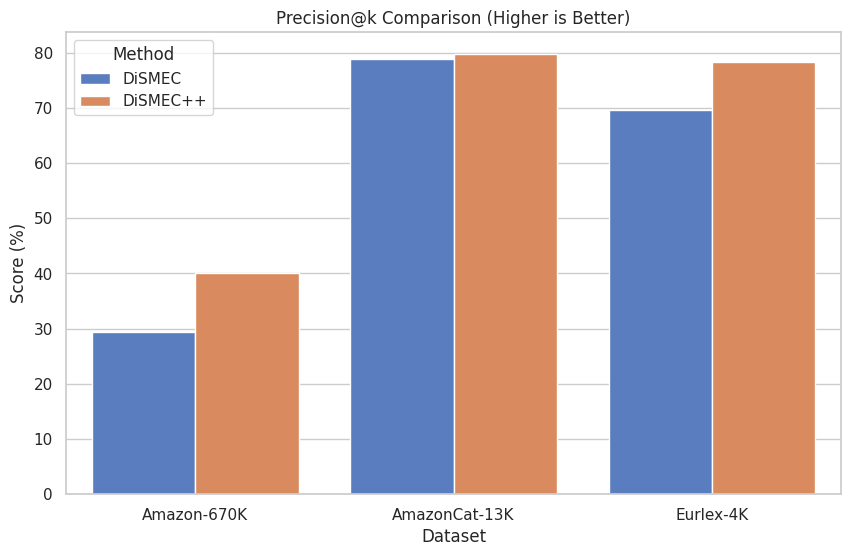

In [4]:
data = {
    'Dataset': ['Amazon-670K', 'AmazonCat-13K', 'Eurlex-4K'] * 2,
    'Method': ['DiSMEC'] * 3 + ['DiSMEC++'] * 3,
    'P@1': [37.02, 93.4, 82.4, 45.7, 94.9, 89.4],
    'P@3': [29.03, 79.1, 68.5, 36.7, 82.14, 78.5],
    'P@5': [22.15, 64.1, 57.7, 38.1, 62.1, 67.1]
}

df = pd.DataFrame(data)

df_melted = df.melt(id_vars=['Dataset', 'Method'],
                    value_vars=['P@1', 'P@3', 'P@5'],
                    var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Dataset', y='Score', hue='Method', palette='muted', ci=None)
plt.title('Precision@k Comparison (Higher is Better)')
plt.ylabel('Score (%)')
plt.legend(title='Method')
plt.show()


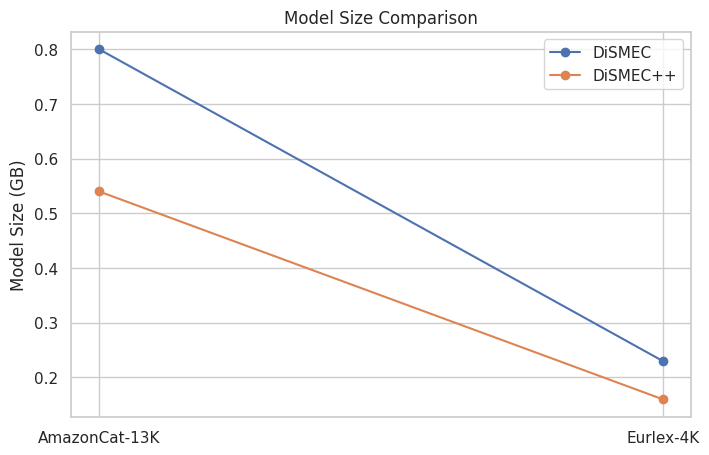

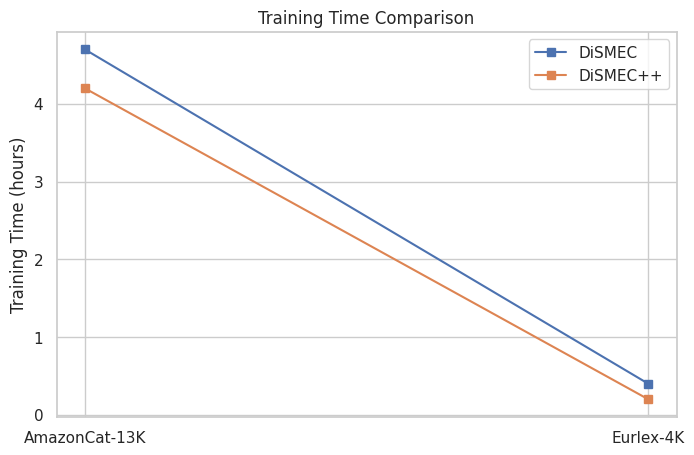

In [5]:
metrics = {
    'Dataset': ['AmazonCat-13K', 'Eurlex-4K'],
    'Model Size (GB) - DiSMEC': [0.8, 0.23],
    'Model Size (GB) - DiSMEC++': [0.54, 0.16],
    'Training Time (hr) - DiSMEC': [4.7, 0.4],
    'Training Time (hr) - DiSMEC++': [4.2, 0.2]
}

df_metrics = pd.DataFrame(metrics)

# Plot Model Sizes
plt.figure(figsize=(8, 5))
plt.plot(df_metrics['Dataset'], df_metrics['Model Size (GB) - DiSMEC'], marker='o', label='DiSMEC')
plt.plot(df_metrics['Dataset'], df_metrics['Model Size (GB) - DiSMEC++'], marker='o', label='DiSMEC++')
plt.title('Model Size Comparison')
plt.ylabel('Model Size (GB)')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training Times
plt.figure(figsize=(8, 5))
plt.plot(df_metrics['Dataset'], df_metrics['Training Time (hr) - DiSMEC'], marker='s', label='DiSMEC')
plt.plot(df_metrics['Dataset'], df_metrics['Training Time (hr) - DiSMEC++'], marker='s', label='DiSMEC++')
plt.title('Training Time Comparison')
plt.ylabel('Training Time (hours)')
plt.legend()
plt.grid(True)
plt.show()
